In [1]:
cd ..

/Users/sgemma.sun/Documents/data101/airbnb-ml


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import src.transform as trans

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
import s3fs
import pyarrow.parquet as pq
import src.const as const

s3 = s3fs.S3FileSystem()

filePath = 's3://airbnb-barcelona/valid/currentDate=2020-03-13'
airbnb_df = pq.ParquetDataset(filePath, filesystem=s3).read_pandas().to_pandas()
airbnb = airbnb_df.drop(columns=const.dropped_columns)

# Transformation

In [4]:
# cat_df = airbnb.select_dtypes(include=['object']).copy()
airbnb.columns

Index(['host_id', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_verifications', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'is_location_exact', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
       'amenities', 'price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'has_availability',
       'availability_365', 'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',

In [5]:
# drop outliers
airbnb = trans.drop_rows_occurs_less_than(airbnb, "cancellation_policy", 2)
airbnb = trans.drop_rows_occurs_less_than(airbnb, "neighbourhood_group_cleansed", 1)
airbnb = trans.drop_rows_occurs_less_than(airbnb, "host_response_time", 1)

In [6]:
# fillna
airbnb = airbnb.fillna(value={"host_is_superhost": False})
airbnb = airbnb.fillna(value={"host_has_profile_pic": False})
airbnb = airbnb.fillna(value={"host_identity_verified": False})
airbnb = airbnb.fillna(value={"host_response_time": "N/A"})

In [7]:
# boolean_to_float
airbnb = trans.foldleft(trans.encode_boolean_to_float, airbnb, const.boolean_to_float_cols)

In [8]:
# element count
airbnb = trans.extract_num_of_items_for_column(airbnb, "host_verifications")
airbnb = trans.extract_num_of_items_for_column(airbnb, "amenities")

In [11]:
airbnb.shape
# ONLY RUN THIS FOR review_scores_rating PREDICTION
# airbnb = airbnb.dropna(subset=["review_scores_rating"])

(15943, 43)

In [12]:
# numeric value
airbnb = airbnb.fillna(airbnb.mean())

# Visualization

[Text(0, 0, 'Eixample'),
 Text(0, 0, 'Ciutat Vella'),
 Text(0, 0, 'Sants-Montjuïc'),
 Text(0, 0, 'Sant Martí'),
 Text(0, 0, 'Gràcia'),
 Text(0, 0, 'Sarrià-Sant Gervasi'),
 Text(0, 0, 'Horta-Guinardó'),
 Text(0, 0, 'Les Corts'),
 Text(0, 0, 'Sant Andreu'),
 Text(0, 0, 'Nou Barris')]

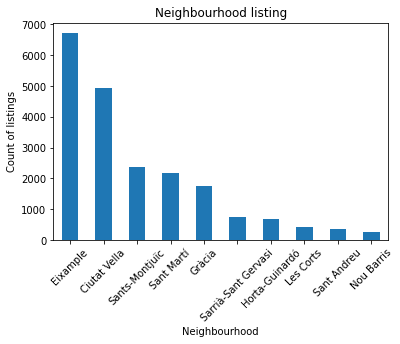

In [11]:
neighbourhood_group = airbnb["neighbourhood_group_cleansed"].value_counts()
viz_1 = neighbourhood_group.plot(kind='bar')
viz_1.set_title('Neighbourhood listing')
viz_1.set_ylabel('Count of listings')
viz_1.set_xlabel('Neighbourhood')
viz_1.set_xticklabels(viz_1.get_xticklabels(), rotation=45)

[Text(0, 0, 'Private room'),
 Text(0, 0, 'Entire home/apt'),
 Text(0, 0, 'Hotel room'),
 Text(0, 0, 'Shared room')]

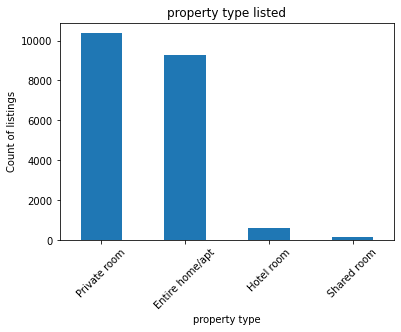

In [12]:
room_type_count = airbnb["room_type"].value_counts()
viz_2=room_type_count.plot(kind='bar')
viz_2.set_title('property type listed')
viz_2.set_ylabel('Count of listings')
viz_2.set_xlabel('property type')
viz_2.set_xticklabels(viz_2.get_xticklabels(), rotation=45)

In [13]:
fig, ax=plt.subplots(figsize=(15,15))
ax = sns.scatterplot(x="latitude", y="longitude", data=airbnb, alpha=0.5, hue="price")

# Encode category before training model

In [13]:
# category encode
category_encoder = trans.encode_category_dic(airbnb)
category_dic = trans.foldleft(category_encoder, {}, const.category_columns)
dic_host_response_time = {'host_response_time': {'N/A': 1, 'a few days or more': 2, 'within a day': 3, 'within a few hours': 4, 'within an hour': 5}}
category_dic = dict(dic_host_response_time, **category_dic)
airbnb = airbnb.replace(category_dic)

# Price prediction

In [22]:
airbnb.columns

Index(['host_id', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_verifications', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'is_location_exact', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
       'amenities', 'price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'has_availability',
       'availability_365', 'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',

In [11]:
y = airbnb["price"]
X = airbnb.drop(columns=['price'])

In [12]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
from sklearn.ensemble import RandomForestRegressor
rnd_regr = RandomForestRegressor(min_samples_leaf=4, random_state=0, n_estimators=100)
rnd_regr.fit(x_train, y_train)
trans.compute_mse_r2(rnd_regr, x_test, y_test)

(0.768674336753933, 57683.43711087292)

In [22]:
trans.compute_mse_r2(rnd_regr, x_train, y_train)

(0.8248245636203511, 39320.50369993874)

In [23]:
import joblib

with s3.open('airbnb-barcelona/models/rnd_reg.price', 'wb') as f:
    joblib.dump(rnd_regr, f)
s3.du('airbnb-barcelona/models/rnd_reg.price')

with s3.open('airbnb-barcelona/models/rnd_reg.price', 'rb') as f:
    loaded_model = joblib.load(f)

sample = x_test.iloc[1]
print("expected: ", y_test.iloc[1])
actual = loaded_model.predict([sample])
print('actual: ', actual)

expected:  45.0
actual:  [57.91014458]


In [47]:
sample = x_test.iloc[1]
print(type(sample))
print(sample[20])
# test_json = x_test.iloc[1].to_json()
# print(test_json)

<class 'pandas.core.series.Series'>
90.0


# review_scores_rating prediction

In [14]:
y = airbnb["review_scores_rating"]
X = airbnb.drop(columns=['review_scores_rating'])
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
from sklearn.ensemble import RandomForestRegressor
rnd_regr = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=50)
rnd_regr.fit(x_train, y_train)
trans.compute_mse_r2(rnd_regr, x_test, y_test)

(0.7216846030949697, 27.983757977759343)

In [38]:
trans.compute_mse_r2(rnd_regr, x_train, y_train)

(0.7756316672320438, 22.427997736873337)

In [67]:
from sklearn.linear_model import Ridge
rig_reg = Ridge(alpha=1)
rig_reg.fit(x_test, y_test)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [68]:
trans.compute_mse_r2(rig_reg, x_test, y_test)

(0.7831023196480246, 21.80839529685893)

In [69]:
trans.compute_mse_r2(rig_reg, x_train, y_train)

(0.7942154492233546, 20.570351360034937)

In [70]:
import joblib

with s3.open('airbnb-barcelona/models/rig_reg.reviews', 'wb') as f:
    joblib.dump(rig_reg, f)

with s3.open('airbnb-barcelona/models/rig_reg.reviews', 'rb') as f:
    loaded_model = joblib.load(f)

In [74]:
sample = x_test.iloc[66]
print("expected: ", y_test.iloc[66])
actual = loaded_model.predict([sample])
print('actual: ', actual)

expected:  90.0
actual:  [94.2035111]
